---
layout: post  
---

In [ ]:
# TODO: test all of the code warntypes!!

In [1]:
import Pkg
pkgs = [
    "BioSequences",
    "Random",
    "BenchmarkTools",
    "Primes",
    "LightGraphs",
    "StatsBase",
    "DataStructures",
    "GraphRecipes",
    "Plots",
    "BioSymbols",
    "StatsPlots",
    "BioAlignments",
    "SparseArrays",
    "PrettyTables"
]

Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [2]:
ORIENTED_KMER = NamedTuple{(:index, :orientation),Tuple{Int,Union{Bool, Missing}}}

NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}

In [3]:
function get_kmer_index(kmers, kmer)
#     @code_warntype get_kmer_index(kmers, kmer)
    index_range = searchsorted(kmers, kmer)
    if !isempty(index_range)
        return first(index_range)
    else
        return nothing
    end
end

get_kmer_index (generic function with 1 method)

In [4]:
function observe(sequence; error_rate = 0.0, alphabet = BioSymbols.ACGT)
#     @code_warntype observe(sequence)
    new_seq = Vector{eltype(sequence)}()
    for character in sequence
        if rand() > error_rate
            # match
            push!(new_seq, character)
        else
            error_type = rand(1:3)
            if error_type == 1
                # mismatch
                push!(new_seq, rand(setdiff(alphabet, character)))
            elseif error_type == 2
                # insertion
                push!(new_seq, rand(alphabet))
                push!(new_seq, character)
            else
                # deletion
                continue
            end
        end
    end
    return_seq = BioSequences.LongDNASeq(new_seq)
    if rand(Bool)
        return_seq = BioSequences.reverse_complement!(return_seq)
    end
    return return_seq
end

observe (generic function with 1 method)

In [5]:
function ordered_edge(a, b)
#     @code_warntype ordered_edge(a, b)
    if a <= b
        return LightGraphs.Edge(a, b)
    else
        return LightGraphs.Edge(b, a)
    end
end

ordered_edge (generic function with 1 method)

In [6]:
function initialize_graph(observations, kmers::Vector{KMER_TYPE}, k) where KMER_TYPE
#     @code_warntype initialize_graph(observations, kmers, k)
    # initalize graph
    graph = LightGraphs.SimpleGraph(length(kmers))
    
    EDGE_TYPE = LightGraphs.SimpleGraphs.SimpleEdge{Int}

    # an individual piece of evidence takes the form of
    # (observation_index = observation #, edge_index = edge # starting from beginning of the observation)

    EVIDENCE_TYPE = NamedTuple{(:observation_index, :edge_index),Tuple{Int64,Int64}}
    
    # evidence takes the form of Edge => [(evidence_1), (evidence_2), ..., (evidence_N)]    
    edge_evidence = Dict{EDGE_TYPE, Vector{EVIDENCE_TYPE}}()
    for (observation_index, observation) in enumerate(observations)
        for edge_index in 1:length(observation)-k
            a_to_b_connection = observation[edge_index:edge_index+k]
            a = BioSequences.canonical(KMER_TYPE(a_to_b_connection[1:end-1]))
            b = BioSequences.canonical(KMER_TYPE(a_to_b_connection[2:end]))
            a_index = get_kmer_index(kmers, a)
            b_index = get_kmer_index(kmers, b)
            edge = ordered_edge(a_index, b_index)
            LightGraphs.add_edge!(graph, edge)
            evidence = (;observation_index, edge_index)
            edge_evidence[edge] = push!(get(edge_evidence, edge, EVIDENCE_TYPE[]), evidence)
        end
    end
    return (graph = graph, edge_evidence = edge_evidence)
end

initialize_graph (generic function with 1 method)

In [58]:
function determine_edge_probabilities(graph, kmers, edge_evidence)
#     @code_warntype determine_edge_probabilities(graph, kmers, edge_evidence)
    outgoing_edge_probabilities = determine_edge_probabilities(graph, kmers, edge_evidence, true)
    incoming_edge_probabilities = determine_edge_probabilities(graph, kmers, edge_evidence, false)
    return outgoing_edge_probabilities, incoming_edge_probabilities
end

function determine_edge_probabilities(graph, kmers, edge_evidence, strand)
#     @code_warntype determine_edge_probabilities(graph, kmers, edge_evidence, strand)
    outgoing_edge_probabilities = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbor_indices = Int[]
        for neighbor in BioSequences.neighbors(kmer)
            index = get_kmer_index(kmers, BioSequences.canonical(neighbor))
            if !isnothing(index)
                push!(downstream_neighbor_indices, index)
            end
        end
        
        # kmer must be in our dataset
        filter!(neighbor_index -> neighbor_index != nothing, downstream_neighbor_indices)
        # must have edge between kmers
        filter!(neighbor_index -> LightGraphs.has_edge(graph, ordered_edge(kmer_index, neighbor_index)), downstream_neighbor_indices)
        sort!(downstream_neighbor_indices)
        
        EDGE_EVIDENCE_TYPE = eltype(values(edge_evidence))
        
        downstream_edge_weights = Int[
            length(get(edge_evidence, ordered_edge(kmer_index, neighbor_index), EDGE_EVIDENCE_TYPE())) for neighbor_index in downstream_neighbor_indices
        ]
        
        non_zero_indices = downstream_edge_weights .> 0
        downstream_neighbor_indices = downstream_neighbor_indices[non_zero_indices]
        downstream_edge_weights = downstream_edge_weights[non_zero_indices]
        
        downstream_edge_likelihoods = downstream_edge_weights ./ sum(downstream_edge_weights)
        for (neighbor_index, likelihood) in zip(downstream_neighbor_indices, downstream_edge_likelihoods)
            outgoing_edge_probabilities[kmer_index, neighbor_index] = likelihood
        end
    end
    return outgoing_edge_probabilities
end

determine_edge_probabilities (generic function with 2 methods)

In [8]:
function assess_alignment(a, b)
#     @code_warntype assess_alignment(a, b)
    pairwise_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), a, b)
    alignment_result = BioAlignments.alignment(pairwise_alignment)
    total_aligned_bases = BioAlignments.count_aligned(alignment_result)
    total_matches = BioAlignments.count_matches(alignment_result)
    total_edits = total_aligned_bases - total_matches
    return (;total_matches, total_edits)
end

assess_alignment (generic function with 1 method)

In [9]:
function assess_path_orientations(path, kmers, initial_orientation)
#     @code_warntype assess_path_orientations(path, kmers, initial_orientation)
    
    ORIENTATION_TYPE = Union{Bool, Missing}
    
    orientations = Vector{ORIENTATION_TYPE}(missing, length(path))
    orientations[1] = true
    
    # I THINK THIS IS WRONG
    # I THINK THIS ORIENTATION SHOULD BE DEPENDANT ON PREVIOUS ORIENTATION!!
    
    for (i, (a, b)) in enumerate(zip(path[1:end-1], path[2:end]))
        kmer_a = kmers[a]
        kmer_b = kmers[b]
        forward_match = all(kmer_a[a_index] == kmer_b[b_index] for (a_index, b_index) in zip(2:length(kmer_a), 1:length(kmer_b)-1))
        reverse_match = all(kmer_a[a_index] == BioSequences.reverse_complement(kmer_b)[b_index] for (a_index, b_index) in zip(2:length(kmer_a), 1:length(kmer_b)-1))
        if forward_match && reverse_match
            # ambiguous orientation
            this_orientation = missing
        elseif forward_match && !reverse_match
            this_orientation = true
        elseif !forward_match && reverse_match
            this_orientation = false
        else
            error("neither orientation matches $kmer_a, $kmer_b")
        end
        orientations[i+1] = this_orientation
    end
    if !ismissing(initial_orientation) && !initial_orientation
        for i in eachindex(orientations)
            orientations[i] = !orientations[i]
        end
    end
    return orientations
end

assess_path_orientations (generic function with 1 method)

In [10]:
function assess_path_likelihood(oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
#     @code_warntype assess_path_likelihood(oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
    # we take it as a given that we are at the current node, so initialize with p=1 and then update with other node likelihoods
    likelihood = 1.0
    total_kmer_count = sum(counts)
    for node in oriented_path[2:end]
        likelihood *= counts[node.index] / total_kmer_count
    end
    for (a, b) in zip(oriented_path[1:end-1], oriented_path[2:end])
        if ismissing(a.orientation)
            # ambiguous orientation
            likelihood *= max(incoming_edge_probabilities[a.index, b.index], incoming_edge_probabilities[a.index, b.index])
        elseif a.orientation
            likelihood *= outgoing_edge_probabilities[a.index, b.index]
        elseif !a.orientation
            likelihood *= incoming_edge_probabilities[a.index, b.index]
        else
            error("unreachable condition")
        end
    end
    return likelihood
end

assess_path_likelihood (generic function with 1 method)

In [11]:
function orient_path(path, orientations)
#     @code_warntype orient_path(path, orientations)
    oriented_path = [(index = i, orientation = o) for (i, o) in zip(path, orientations)] 
    return oriented_path
end

orient_path (generic function with 1 method)

In [12]:
function assess_emission(current_orientation, current_kmer_index, observed_kmer, kmers)
#     @code_warntype assess_emission(current_orientation, current_kmer_index, observed_kmer, kmers)
    
    current_kmer_sequence = kmers[current_kmer_index]
    observed_kmer_sequence = kmers[observed_kmer.index]
    if !observed_kmer.orientation
        observed_kmer_sequence = BioSequences.reverse_complement(observed_kmer_sequence)
    end
    
    forward_emission_match = current_kmer_sequence[end] == observed_kmer_sequence[end]
    reverse_emission_match = BioSequences.reverse_complement(current_kmer_sequence)[end] == observed_kmer_sequence[end]
    
    if !ismissing(current_orientation) && current_orientation
        emission_match = forward_emission_match
        evaluated_orientation = current_orientation
    elseif !ismissing(current_orientation) && !current_orientation
        emission_match = reverse_emission_match
        evaluated_orientation = current_orientation
    elseif ismissing(current_orientation)
        # ambiguous orientation
        if forward_emission_match && !reverse_emission_match
            emission_match = forward_emission_match
            evaluated_orientation = true
        elseif !forward_emission_match && reverse_emission_match
            emission_match = reverse_emission_match
            evaluated_orientation = false
        elseif forward_emission_match && reverse_emission_match
            @warn "is this possible?"
            @show current_kmer_sequence, observed_kmer_sequence
            emission_match = true
            evaluated_orientation = missing
        elseif !forward_emission_match && !reverse_emission_match
            emission_match = false
            evaluated_orientation = missing
        end
    else
        error("unreachable condition")
    end
    return (emission_match = emission_match, evaluated_orientation = evaluated_orientation)
end

assess_emission (generic function with 1 method)

In [13]:
function assess_path(path,
    observed_kmer,
    kmers,
    counts,
    initial_orientation,
    outgoing_edge_probabilities,
    incoming_edge_probabilities,
    error_rate)

#     @code_warntype assess_path(path,
#     observed_kmer,
#     kmers,
#     counts,
#     initial_orientation,
#     outgoing_edge_probabilities,
#     incoming_edge_probabilities,
#     error_rate)
    
    orientations = assess_path_orientations(path, kmers, initial_orientation)
    emission_match, evaluated_orientation = assess_emission(last(orientations), last(path), observed_kmer, kmers)
    # assert an orientation if we found one
    if ismissing(last(orientations)) && !ismissing(evaluated_orientation)
        orientations[end] = evaluated_orientation
    end
    oriented_path = orient_path(path, orientations)
    path_likelihood = assess_path_likelihood(oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
    path_likelihood *= emission_match ? (1.0 - error_rate) : error_rate
    edit_distance = !emission_match + abs(length(path) - 2)
    
    return (oriented_path = oriented_path, path_likelihood = path_likelihood, edit_distance = edit_distance)    
end

assess_path (generic function with 1 method)

In [14]:
function find_outneighbors(orientation, kmer_index, outgoing_edge_probabilities, incoming_edge_probabilities)
#     @code_warntype find_outneighbors(orientation, kmer_index, outgoing_edge_probabilities, incoming_edge_probabilities)
    if ismissing(orientation)
        outneighbors = vcat(
            first(SparseArrays.findnz(outgoing_edge_probabilities[kmer_index, :])),
            first(SparseArrays.findnz(incoming_edge_probabilities[kmer_index, :]))
        )
    elseif orientation
        outneighbors = first(SparseArrays.findnz(outgoing_edge_probabilities[kmer_index, :]))
    else
        outneighbors = first(SparseArrays.findnz(incoming_edge_probabilities[kmer_index, :]))
    end
    return outneighbors
end

find_outneighbors (generic function with 1 method)

In [15]:
function assess_insertion(previous_orientation, current_kmer_index, observed_kmer, kmers, counts, error_rate)
#     @code_warntype assess_insertion(previous_orientation, current_kmer_index, observed_kmer, kmers, counts, error_rate)
    
    transition_likelihood = error_rate
    state_likelihood = counts[current_kmer_index] / sum(counts)
    emission_match, evaluated_orientation = assess_emission(previous_orientation, current_kmer_index, observed_kmer, kmers)
    
    oriented_path = ORIENTED_KMER[(index = current_kmer_index, orientation = evaluated_orientation)]
    
    emission_likelihood = emission_match ? (1.0 - error_rate) : error_rate
    path_likelihood = state_likelihood * transition_likelihood * emission_likelihood
    
    transition_edit_distance = 1
    edit_distance = !emission_match + transition_edit_distance
    
    return (oriented_path = oriented_path, path_likelihood = path_likelihood, edit_distance = edit_distance)
end

assess_insertion (generic function with 1 method)

In [16]:
function find_optimal_path(observed_kmer,
    previous_kmer_index,
    previous_orientation,
    current_kmer_index,
    graph, 
    shortest_paths, 
    kmers, 
    counts, 
    outgoing_edge_probabilities, 
    incoming_edge_probabilities,
    error_rate)
    
#     @code_warntype find_optimal_path(observed_kmer,
#     previous_kmer_index,
#     previous_orientation,
#     current_kmer_index,
#     graph, 
#     shortest_paths, 
#     kmers, 
#     counts, 
#     outgoing_edge_probabilities, 
#     incoming_edge_probabilities,
#     error_rate)

    path_likelihood = 0.0
    oriented_path = Vector{ORIENTED_KMER}()
    edit_distance = 0

    if current_kmer_index == previous_kmer_index
        # could be a self loop, check this first
        if LightGraphs.has_edge(graph, LightGraphs.Edge(previous_kmer_index, current_kmer_index))
            this_path = [previous_kmer_index, current_kmer_index]
            this_oriented_path, this_likelihood, this_edit_distance = 
                assess_path(this_path,
                            observed_kmer,
                            kmers,
                            counts,
                            previous_orientation,
                            outgoing_edge_probabilities,
                            incoming_edge_probabilities,
                            error_rate)
            if this_likelihood > path_likelihood
                path_likelihood = this_likelihood
                oriented_path = this_oriented_path
                edit_distance = this_edit_distance
            end
        end
        
        # consider an insertion in observed sequence relative to the reference graph
        this_oriented_path, this_likelihood, this_edit_distance = assess_insertion(previous_orientation, current_kmer_index, observed_kmer, kmers, counts, error_rate)
        if this_likelihood > path_likelihood
            path_likelihood = this_likelihood
            oriented_path = this_oriented_path
            edit_distance = this_edit_distance
        end
        
        # consider a deletion in observed sequene relative to the reference graph
        # see if this has any neighbors that circle back, and evaluate the likelihood for each
        outneighbors = find_outneighbors(previous_orientation, previous_kmer_index, outgoing_edge_probabilities, incoming_edge_probabilities)
        for outneighbor in outneighbors
            if LightGraphs.has_path(graph, outneighbor, current_kmer_index)
                # manually build path
                this_path = [previous_kmer_index, shortest_paths[previous_kmer_index][current_kmer_index]...]
                this_oriented_path, this_likelihood, this_edit_distance = 
                    assess_path(this_path,
                                observed_kmer,
                                kmers,
                                counts,
                                previous_orientation,
                                outgoing_edge_probabilities,
                                incoming_edge_probabilities,
                                error_rate)
                if this_likelihood > path_likelihood
                    path_likelihood = this_likelihood
                    oriented_path = this_oriented_path
                    edit_distance = this_edit_distance
                end
            end
        end
    elseif LightGraphs.has_path(graph, previous_kmer_index, current_kmer_index)   
        this_path = shortest_paths[previous_kmer_index][current_kmer_index]
        this_oriented_path, this_likelihood, this_edit_distance = 
            assess_path(this_path,
                        observed_kmer,
                        kmers,
                        counts,
                        previous_orientation,
                        outgoing_edge_probabilities,
                        incoming_edge_probabilities,
                        error_rate)
        if this_likelihood > path_likelihood
            path_likelihood = this_likelihood
            oriented_path = this_oriented_path
            edit_distance = this_edit_distance
        end
    end
    
    return (oriented_path = oriented_path, path_likelihood = path_likelihood, edit_distance = edit_distance)
end

find_optimal_path (generic function with 1 method)

In [17]:
function assess_alignment_accuracy(alignment_result)
#     @code_warntype assess_alignment_accuracy(alignment_result)
    return alignment_result.total_matches / (alignment_result.total_matches + alignment_result.total_edits)
end

assess_alignment_accuracy (generic function with 1 method)

In [18]:
function assess_optimal_alignment(kmer, observed_kmer)
#     @code_warntype assess_optimal_alignment(kmer, observed_kmer)

    forward_alignment_result = assess_alignment(kmer, observed_kmer)
    forward_alignment_accuracy = assess_alignment_accuracy(forward_alignment_result)

    reverse_alignment_result = assess_alignment(kmer, BioSequences.reverse_complement(observed_kmer))
    reverse_alignment_accuracy = assess_alignment_accuracy(reverse_alignment_result)

    if forward_alignment_accuracy > reverse_alignment_accuracy
        alignment_result = forward_alignment_result
        orientation = true
    elseif forward_alignment_accuracy < reverse_alignment_accuracy
        alignment_result = reverse_alignment_result
        orientation = false
    elseif forward_alignment_accuracy == reverse_alignment_accuracy
        alignment_result, orientation = rand(((forward_alignment_result, missing), (reverse_alignment_result, missing)))
    end

    return (alignment_result = alignment_result, orientation = orientation)
    
end

assess_optimal_alignment (generic function with 1 method)

In [19]:
function backtrack_optimal_path(kmer_likelihoods, arrival_paths, edit_distances)
#     @code_warntype backtrack_optimal_path(kmer_likelihoods, arrival_paths, edit_distances)
    
    maximum_likelihood = maximum(kmer_likelihoods[:, end])

    maximum_likelihood_path_index = rand(findall(kmer_likelihoods[:, end] .== maximum_likelihood))

    maximum_likelihood_edit_distance = edit_distances[maximum_likelihood_path_index, end]

    maximum_likelihood_path = arrival_paths[maximum_likelihood_path_index, end]


    for observed_path_index in size(kmer_likelihoods, 2)-1:-1:1
        maximum_likelihood_arrival_path = arrival_paths[maximum_likelihood_path_index, observed_path_index][1:end-1]
        maximum_likelihood_path = vcat(maximum_likelihood_arrival_path, maximum_likelihood_path)
        maximum_likelihood_path_index = first(maximum_likelihood_path).index
    end
    
    unlogged_maximum_likelihood = MathConstants.e^BigFloat(maximum_likelihood)
    unlogged_total_likelihood = sum(likelihood -> MathConstants.e^BigFloat(likelihood), kmer_likelihoods[:, end])
    relative_likelihood = unlogged_maximum_likelihood / unlogged_total_likelihood
    
    return (
        maximum_likelihood_path = maximum_likelihood_path,
        maximum_likelihood_edit_distance = maximum_likelihood_edit_distance,
        relative_likelihood = relative_likelihood)
    
end

backtrack_optimal_path (generic function with 1 method)

In [20]:
function initialize_viterbi(graph, observed_path, kmers, counts, error_rate)
#     @code_warntype initialize_viterbi(graph, observed_path, kmers, counts, error_rate)
    edit_distances = Array{Union{Int, Missing}}(missing, LightGraphs.nv(graph.graph), length(observed_path))
    arrival_paths = Array{Union{Vector{ORIENTED_KMER}, Missing}}(missing, LightGraphs.nv(graph.graph), length(observed_path))
    kmer_likelihoods = Array{Float64}(undef, LightGraphs.nv(graph.graph), length(observed_path)) .= -Inf
    kmer_likelihoods[:, 1] .= counts ./ sum(counts)

    observed_kmer_sequence = orient_oriented_kmer(kmers, first(observed_path))
    for (kmer_index, kmer) in enumerate(kmers)
        
        alignment_result, orientation = assess_optimal_alignment(kmer, observed_kmer_sequence)

        for match in 1:alignment_result.total_matches
            kmer_likelihoods[kmer_index, 1] *= (1.0 - error_rate)
        end
        for edit in 1:alignment_result.total_edits
            kmer_likelihoods[kmer_index, 1] *= error_rate
        end
        if kmer_likelihoods[kmer_index, 1] > 0.0
            arrival_paths[kmer_index, 1] = [(index = kmer_index, orientation = orientation)]
            edit_distances[kmer_index, 1] = alignment_result.total_edits
        end
    end
    kmer_likelihoods[:, 1] ./= sum(kmer_likelihoods[:, 1])
    kmer_likelihoods[:, 1] .= log.(kmer_likelihoods[:, 1])
    
    return (kmer_likelihoods = kmer_likelihoods, arrival_paths = arrival_paths, edit_distances = edit_distances)
end

initialize_viterbi (generic function with 1 method)

In [21]:
function viterbi_maximum_likelihood_path(graph, observation, kmers, counts, error_rate; debug = false)
#     @code_warntype viterbi_maximum_likelihood_path(graph, observation, kmers, counts, error_rate)

    observed_path = sequence_to_oriented_path(observation, kmers)
    
    outgoing_edge_probabilities, incoming_edge_probabilities = determine_edge_probabilities(graph.graph, kmers, graph.edge_evidence)
    
    shortest_paths = LightGraphs.enumerate_paths(LightGraphs.floyd_warshall_shortest_paths(graph.graph))
    
    kmer_likelihoods, arrival_paths, edit_distances = initialize_viterbi(graph, observed_path, kmers, counts, error_rate)
    
    for current_observation_index in 2:length(observed_path)
        observed_kmer = observed_path[current_observation_index]
        if debug
            println("current_observation_index = $(current_observation_index)")
            println("observed_kmer = $(observed_kmer)")
        end
        for (current_kmer_index, current_kmer) in enumerate(kmers)
            if debug
                println("\t\tcurrent_kmer_index = $(current_kmer_index)")
                println("\t\tcurrent_kmer = $(current_kmer)")
            end
            for (previous_kmer_index, previous_kmer) in enumerate(kmers)
                if debug
                    println("\tprevious_kmer_index = $(previous_kmer_index)")
                    println("\tprevious_kmer = $(previous_kmer)")
                end

                previous_likelihood = kmer_likelihoods[previous_kmer_index, current_observation_index - 1]
                current_likelihood = kmer_likelihoods[current_kmer_index, current_observation_index]
                previous_arrival_path = arrival_paths[previous_kmer_index, current_observation_index - 1]
                if current_likelihood > previous_likelihood && !ismissing(previous_arrival_path)
                    # we've determined that there is no way to get to this kmer being evaluated
                    continue
                else
                    if ismissing(previous_arrival_path)
                        previous_orientation = missing
                    else
                        previous_orientation = last(arrival_paths[previous_kmer_index, current_observation_index - 1]).orientation
                    end
                    optimal_path_result =
                        find_optimal_path(observed_kmer,
                            previous_kmer_index,
                            previous_orientation,
                            current_kmer_index,
                            graph.graph, 
                            shortest_paths, 
                            kmers, 
                            counts,
                            outgoing_edge_probabilities, 
                            incoming_edge_probabilities,
                            error_rate)
                    if debug
                        for propertyname in propertynames(optimal_path_result)
                            println("\t\t\t$propertyname = $(getproperty(optimal_path_result, propertyname))")
                        end
                    end
                    this_likelihood = previous_likelihood + log(optimal_path_result.path_likelihood)

                    if this_likelihood > current_likelihood
                        kmer_likelihoods[current_kmer_index, current_observation_index] = this_likelihood
                        arrival_paths[current_kmer_index, current_observation_index] = optimal_path_result.oriented_path
                        previous_edit_distance = edit_distances[previous_kmer_index, current_observation_index - 1]
                        edit_distances[current_kmer_index, current_observation_index] = previous_edit_distance + optimal_path_result.edit_distance 
                    end
                end
            end
        end
    end
    if debug
        my_show(arrival_paths, kmers, title = "Arrival Paths")
        my_show(kmer_likelihoods, kmers, title="Kmer Likelihoods")
        my_show(edit_distances, kmers, title="Edit Distances")
    end
    return backtrack_optimal_path(kmer_likelihoods, arrival_paths, edit_distances)
end

viterbi_maximum_likelihood_path (generic function with 1 method)

In [22]:
function count_kmers(::Type{KMER_TYPE}, sequence::BioSequences.LongSequence) where KMER_TYPE
#     @code_warntype count_kmers(KMER_TYPE, sequence)
    canonical_kmer_counts = DataStructures.OrderedDict{KMER_TYPE, Int}()
    canonical_kmer_iterator = (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(KMER_TYPE, sequence))
    for canonical_kmer in canonical_kmer_iterator
        canonical_kmer_counts[canonical_kmer] = get(canonical_kmer_counts, canonical_kmer, 0) + 1
    end
    return canonical_kmer_counts
end


count_kmers (generic function with 1 method)

In [23]:
function count_kmers(::Type{KMER_TYPE}, sequences) where KMER_TYPE
#     @code_warntype count_kmers(KMER_TYPE, sequences)
    joint_kmer_counts = DataStructures.OrderedDict{KMER_TYPE, Int}()
    for sequence in sequences
        sequence_kmer_counts = count_kmers(KMER_TYPE, sequence)
        merge!(+, joint_kmer_counts, sequence_kmer_counts)
    end
    sort!(joint_kmer_counts)
end

count_kmers (generic function with 2 methods)

In [24]:
function oriented_path_to_sequence(oriented_path, kmers)
#     @code_warntype oriented_path_to_sequence(oriented_path, kmers)
    initial_kmer = first(oriented_path)
    initial_kmer_sequence = orient_oriented_kmer(kmers, initial_kmer)
    
    sequence = BioSequences.LongDNASeq(initial_kmer_sequence)
    for i in 2:length(oriented_path)
        this_kmer = oriented_path[i]
        this_kmer_sequence = kmers[this_kmer.index]
        if !this_kmer.orientation
            this_kmer_sequence = BioSequences.reverse_complement(this_kmer_sequence)
        end
        push!(sequence, this_kmer_sequence[end])
    end
    return sequence
end

oriented_path_to_sequence (generic function with 1 method)

In [25]:
function orient_oriented_kmer(kmers, kmer)
#     @code_warntype orient_oriented_kmer(kmers, kmer)
    oriented_kmer_sequence = kmers[kmer.index]
    if !kmer.orientation
        oriented_kmer_sequence = BioSequences.reverse_complement(oriented_kmer_sequence)
    end
    return oriented_kmer_sequence
end

orient_oriented_kmer (generic function with 1 method)

In [26]:
function sequence_to_oriented_path(sequence, kmers::Vector{BioSequences.Mer{ALPHABET, K}}) where {ALPHABET, K}
#     @code_warntype sequence_to_oriented_path(sequence, kmers)
    observed_path = Vector{ORIENTED_KMER}(undef, length(sequence)-K+1)
    for (i, kmer) in enumerate(BioSequences.each(BioSequences.Mer{ALPHABET, K}, observation))
        canonical_kmer = BioSequences.canonical(kmer.fw)
        index = get_kmer_index(kmers, canonical_kmer)
        orientation = kmer.fw == canonical_kmer
        observed_path[i] = (index = index, orientation = orientation)
    end
    return observed_path
end

sequence_to_oriented_path (generic function with 1 method)

In [27]:
function plot_kmer_frequency_spectra(counts)
    kmer_counts_hist = StatsBase.countmap(c for c in counts)
    xs = collect(keys(kmer_counts_hist))
    ys = collect(values(kmer_counts_hist))

    StatsPlots.plot(
        xs,
        ys,
        xlims = (0, maximum(xs) + 1),
        ylims = (0, maximum(ys) + 1),
        seriestype = :scatter,
        legend = false,
        xlabel = "observed frequency",
        ylabel = "# of kmers"
    )
end

plot_kmer_frequency_spectra (generic function with 1 method)

In [28]:
function my_show(x::Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Array{NamedTuple{(:observation_index, :edge_index),Tuple{Int64,Int64}},1}})
    for (k, vs) in x
        println(k)
        for v in vs
            println("\t$v")
        end
    end
end

function my_show(vector::AbstractVector{T}; kwargs...) where T <: ORIENTED_KMER
    return PrettyTables.pretty_table(
    vector,
    tf = PrettyTables.tf_markdown;
    kwargs...)
end

function my_show(array::AbstractMatrix, kmers; kwargs...)
    return PrettyTables.pretty_table(
    array,
    ["$i" for i in 1:size(array, 2)],
    row_names = kmers,
    tf = PrettyTables.tf_markdown;
    kwargs...)
end

function my_show(arrival_paths::AbstractMatrix{T}, kmers; kwargs...) where {T <: Union{Missing, Vector{ORIENTED_KMER}}}
    string_arrival_paths = Array{Union{String, Missing}, 2}(missing, size(arrival_paths)...)
    for index in eachindex(arrival_paths)
        cell = arrival_paths[index]
        if !ismissing(cell)
            cell_strings = []
            for node in cell
                node_string = "(" * join(["$(getfield(node, field))" for field in propertynames(node)], ", ") * ")"
                push!(cell_strings, node_string)
            end
            cell_string = '[' * join(cell_strings, ", ") * ']'
            string_arrival_paths[index] = cell_string
        end
    end
    return my_show(string_arrival_paths, kmers; kwargs...)
end

my_show (generic function with 4 methods)

In [29]:
function plot_graph(graph, kmers, counts)
    graph_hash = hash(sort(graph.graph.fadjlist), hash(graph.graph.ne))

    p = GraphRecipes.graphplot(
        graph.graph,
        names = 1:length(kmers),
        node_weights = counts,
        markersize = 0.2,
        hover=false,
        fontsize=12)

    filename = "/assets/images/$(graph_hash).svg"
    Plots.savefig(p, dirname(pwd()) * filename)
    display(p)
    display("text/markdown", "![]($filename)")
end

plot_graph (generic function with 1 method)

In [30]:
k = 1
KMER_TYPE = BioSequences.DNAMer{k}

BioSequences.Mer{BioSequences.DNAAlphabet{2},1}

In [31]:
sequence = BioSequences.randdnaseq(Random.seed!(1), 1)

1nt DNA Sequence:
T

In [32]:
error_rate = 0.00

0.0

In [33]:
observations = [sequence]

1-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 T

In [34]:
kmer_counts = count_kmers(KMER_TYPE, observations)

OrderedCollections.OrderedDict{BioSequences.Mer{BioSequences.DNAAlphabet{2},1},Int64} with 1 entry:
  A => 1

In [35]:
kmers = collect(keys(kmer_counts))
counts = collect(values(kmer_counts))

1-element Array{Int64,1}:
 1

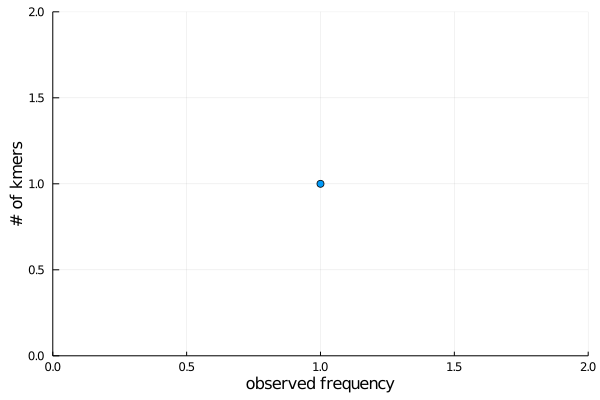

In [36]:
plot_kmer_frequency_spectra(counts)

In [37]:
graph = initialize_graph(observations, kmers, k)
# my_show(graph.edge_evidence)
# plot_graph(graph, kmers, counts)

(graph = {1, 0} undirected simple Int64 graph, edge_evidence = Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Array{NamedTuple{(:observation_index, :edge_index),Tuple{Int64,Int64}},1}}())

In [38]:
observation = first(observations)

1nt DNA Sequence:
T

In [39]:
my_show(sequence_to_oriented_path(observation, kmers))

| index | orientation |
| Int64 |       Bool? |
|-------|-------------|
|     1 |       false |


In [59]:
optimal_path = viterbi_maximum_likelihood_path(graph, observation, kmers, counts, error_rate)

(maximum_likelihood_path = NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((1, false))], maximum_likelihood_edit_distance = 0, relative_likelihood = 1.0)

In [60]:
my_show(optimal_path.maximum_likelihood_path, title = "Maximum Likelihood Path")

Maximum Likelihood Path
| index | orientation |
| Int64 |       Bool? |
|-------|-------------|
|     1 |       false |


In [63]:
sequence_to_oriented_path(sequence, kmers)

1-element Array{NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}},1}:
 NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((1, false))

In [64]:
oriented_path_to_sequence(sequence_to_oriented_path(observation, kmers), kmers)

1nt DNA Sequence:
T

In [ ]:
# @code_warntype get_kmer_index(kmers, BioSequences.DNAMer(BioSequences.randdnaseq(1)))

# @code_warntype observe(BioSequences.randdnaseq(4))

# @code_warntype ordered_edge(rand(Int), rand(Int))

# @code_warntype initialize_graph(observations, kmers, k)

# @code_warntype determine_edge_probabilities(graph.graph, kmers, graph.edge_evidence)

# @code_warntype determine_edge_probabilities(graph.graph, kmers, graph.edge_evidence, false)

# @code_warntype assess_alignment(BioSequences.DNAMer(BioSequences.randdnaseq(3)), BioSequences.DNAMer(BioSequences.randdnaseq(3)))

# @code_warntype assess_path_orientations([1], kmers, true)

# @code_warntype assess_path_likelihood([(index = 1, orientation = true), (index = 2, orientation = false)], [BioSequences.mer"A", BioSequences.mer"C"], [1,1], SparseArrays.spzeros(2, 2), SparseArrays.spzeros(2, 2))

# @code_warntype orient_path([1], [true])

# @code_warntype assess_emission(true, 1, (index = 1, orientation = true), [BioSequences.mer"A"])